In [0]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
VOCAB_SIZE = 1000
EMBEDDING_DIM = 50
SEQ_LEN = 10
BATCH_SIZE = 32

In [0]:
emb = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)

In [0]:
emb(torch.from_numpy(np.array([2, 123, 3])).unsqueeze(0)).shape

torch.Size([1, 3, 50])

In [0]:
class Encoder(nn.Module):

    def __init__(
        self,
        embedding: nn.Module,
        embedding_dim: int,
        lstm_hidden_dim: int = 16,
        lstm_layer_num: int = 4,
    ):
        super(Encoder, self).__init__()

        self._lstm_hidden_dim = lstm_hidden_dim
        self._lstm_layer_num = lstm_layer_num
        self._embedding = embedding
        self._embedding_dim = embedding_dim

        self._lstm = nn.LSTM(
            input_size=self._embedding_dim,
            hidden_size=self._lstm_hidden_dim,
            num_layers=self._lstm_layer_num,
            batch_first=True
        )

    def forward(self, sentences):
        embed = self._embedding(sentences)  # (batch_size, seq_len, embedding_dim)

        out, hidden = self._lstm(embed)
        self._lstm_hiddens = out
        return self._lstm_hiddens

In [0]:
embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM, )

In [0]:
encoder = Encoder(
    embedding=embedding,
    embedding_dim=EMBEDDING_DIM,
)

In [0]:
dummpy_input = torch.Tensor([12, 3, 3] + [0]*(SEQ_LEN-len([12, 3, 3]))).long()
dummpy_input = dummpy_input.repeat(BATCH_SIZE).view(BATCH_SIZE, -1)

In [0]:
dummpy_input

tensor([[12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],
        [12,  3,  3,  0,  0,  0,  0,  0,  0,  0],


In [0]:
dummpy_input.shape  # (batch_size, seq_len)

torch.Size([32, 10])

In [0]:
encoder(dummpy_input).shape  # (batch_size, seq_len, lstm_hidden_dim)

torch.Size([32, 10, 16])

In [0]:
class Decoder(nn.Module):

    def __init__(self,
        embedding: nn.Module,
        embedding_dim: int,
        vocab_size: int,
        lstm_hidden_dim: int = 16,
        lstm_layer_num: int = 4,
    ):
        super(Decoder, self).__init__()

        self._lstm_hidden_dim = lstm_hidden_dim
        self._lstm_layer_num = lstm_layer_num
        self._embedding = embedding
        self._embedding_dim = embedding_dim
        self._vocab_size = vocab_size

        self._lstm = nn.LSTM(
            self._embedding_dim,
            hidden_size=self._lstm_hidden_dim,
            num_layers=self._lstm_layer_num,
            batch_first=True
        )

        self._linear = nn.Linear(
            self._lstm_hidden_dim,
            self._vocab_size
        )

    def forward(self, sequences, encoder_hiddens, hidden=None):
        self._encoder_hiddens = encoder_hiddens  # (batch_size, encoder_seq_len, lstm_hidden_dim)
        self._encoder_input_seqlen = encoder_hiddens.size(1)
        self._seq_len = sequences.size(1)

        embed = self._embedding(sequences)

        if hidden:
            out, hidden = self._lstm(embed, hidden)
        else:
            out, hidden = self._lstm(embed)

        self._decorder_outputs = []
        self._attention_weights = []
        for i in range(self._seq_len):
            ith_hidden = out[:, i, :]
            ith_hidden_repeated = ith_hidden.repeat(1, self._encoder_input_seqlen).view(-1,self._encoder_input_seqlen, self._lstm_hidden_dim)  # (batch_size, encoder_seq_len, lstm_hiden_dim)
            attention_weight = nn.Softmax(dim=1)((self._encoder_hiddens * ith_hidden_repeated).sum(axis=2))  # (batch_size, encoder_seq_len)
            self._attention_weights.append(attention_weight.detach().numpy())
            attention_weight_repeated = attention_weight.repeat(1, self._lstm_hidden_dim).view(-1, self._encoder_input_seqlen, self._lstm_hidden_dim)
            #print(attention_weight_repeated.shape)
            context_vec = (self._encoder_hiddens * attention_weight_repeated).sum(axis=1)
            #print(context_vec.shape)
            ith_out = self._linear(context_vec + ith_hidden)
            ith_out = nn.Softmax(dim=1)(ith_out)
            self._decorder_outputs.append(ith_out)

        return self._decorder_outputs, hidden, np.array(self._attention_weights).transpose(1, 0, 2)

In [0]:
decorder = Decoder(
    embedding=embedding,
    embedding_dim=EMBEDDING_DIM,
    vocab_size=VOCAB_SIZE
)

In [0]:
lstm_hiddens = encoder(dummpy_input)

In [0]:
decoder_outs, hidden, attention_weights = decorder(dummpy_input, lstm_hiddens)

In [0]:
len(decoder_outs)  # seq_len

10

In [0]:
decoder_outs[0].shape  # (batch_size, vocab_size)

torch.Size([32, 1000])

In [0]:
ce_loss = nn.CrossEntropyLoss()

In [0]:
ce_losses = []

for do in decoder_outs:
    teacher_labels = torch.ones(BATCH_SIZE).long()
    ce_losses.append(ce_loss(do, teacher_labels))

In [0]:
np.array(attention_weights).shape  # (batch_size, seq_len, seq_len)

(32, 10, 10)

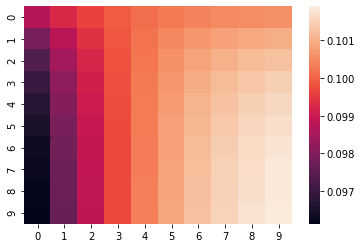

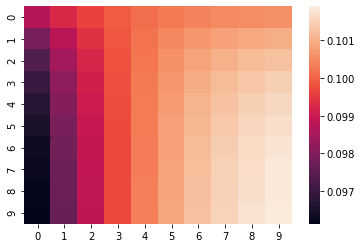

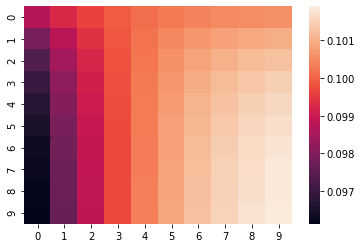

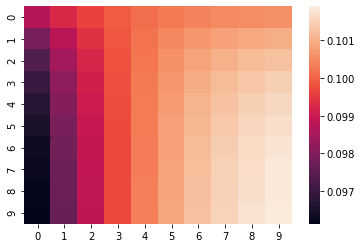

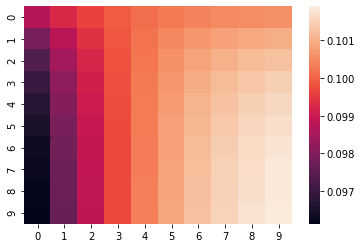

In [0]:
for i in range(5):
    sns.heatmap(np.array(attention_weights)[i, :, :])
    plt.show()

In [0]:
decorder(dummpy_input, lstm_hiddens, hidden)

([tensor([[0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          ...,
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011]],
         grad_fn=<SoftmaxBackward>),
  tensor([[0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          ...,
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011]],
         grad_fn=<SoftmaxBackward>),
  tensor([[0.0010, 0.0008, 0.0007,  ..., 0.0012, 0.0010, 0.0011],
          [0.0010, 0.0008, 0.0007,  